# Data Collection

For this report, we used posts in Reddit, a social media platform where people can create communities (subreddits) to discuss several topics. For this report, we focused on communities on climate change and collected those posts that are new and hot in the respective subreddit.

The selected subreddits are: 'climatechange', 'climate_science', 'climate', 'environment', 'GlobalClimateChange', 'climate_change', 'ClimateChangeSurprise'

To gather the data set, we used the Reddit API. We created a developer account to get the access credentials to work with this API. Additionally, we used a Python package called Prawn ("Python Reddit API Wrapper"). This wrapper facilitates the interactions with the API.

The final dataset has the following features:

- Title: The post title
- Score: It is a net score that equals upvotes minus downvotes for a particular Reddit post
- Author: Author of the post 
- Time: Data of the post
- Comments: Number of comments done to the post
- UpvoteRatio: It is the ratio between upvotes and total votes
- PostId: Unique identifier for the vote
- Subreddit: Name of the subreddit
- is_nsfw: The content is not safe for work
- SelfText: Is the text in the post
- IsSelfText: This boolean tells if the post has self text (In some cases, there is a link or picture instead)
- IsPinned: Refers to whether a post is pinned to a user's profile page
- IsStickied: Indicates the post is pinned to a subreddit
- IsLocked: This boolean indicates if users are able to make new comments on the post

In [1]:
import csv
import pandas as pd
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import chi2_contingency
from wordcloud import WordCloud
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import plotly.express as px
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
import re

In [2]:
df = pd.read_csv('climate_change_sentiment.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15975 entries, 0 to 15974
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         15975 non-null  object 
 1   Score         15975 non-null  int64  
 2   Autor         15518 non-null  object 
 3   Time          15975 non-null  float64
 4   Comments      15975 non-null  int64  
 5   UpvoteRatio   15975 non-null  float64
 6   PostId        15975 non-null  object 
 7   Subreddit     15975 non-null  object 
 8   is_nsfw       15975 non-null  bool   
 9   SelfText      2398 non-null   object 
 10  IsSelfText    15975 non-null  bool   
 11  IsPinned      15975 non-null  bool   
 12  IsStickied    15975 non-null  bool   
 13  IsLocked      15975 non-null  bool   
 14  Sentiment_v   15975 non-null  object 
 15  Sentiment_hf  15975 non-null  object 
dtypes: bool(5), float64(2), int64(2), object(7)
memory usage: 1.4+ MB


Note:

As we can see, the SelfText column has more than 75% null values. Therefore, we'll going to drop that column. Also, the PostId column has just random unique values. Consequently, we will drop that column as well. Finally, 'Sentiment_v' will be removed; we will use 'Sentiment_hf' instead for sentiment.

In [4]:
# Droping columns
df = df.drop(['PostId', 'SelfText', 'Sentiment_v'],axis=1)

In [5]:
# check the unique values in each columns
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in Title: ["I'm afraid climate change is going to kill me! Help!"
 'The r/climatechange Verified User Flair Program'
 'How come some environmentalists are against carbon capture and storage?'
 ... 'Berkeley Lab scientists identify new driver behind Arctic warming'
 'Snowfall less sensitive to warming in Karakoram than in Himalayas due to a unique seasonal cycle'
 'Exposed: Corporate cash is the lifeblood of climate change denial on Capitol Hill']
Unique values in Score: [ 718   30   75 ... 2667 2649 2577]
Unique values in Autor: ['Will_Power' 'technologyisnatural' 'SnooMarzipans7682' ... 'rspix000'
 'madreader121' 'xabby']
Unique values in Time: [1.55010375e+09 1.66111520e+09 1.69798679e+09 ... 1.41548544e+09
 1.41369371e+09 1.41036847e+09]
Unique values in Comments: [ 534   14  296   26   30   34  124    1    2  169  117   19    7  416
   96   57  676    0    9   13    3    5   67   33   93  372  365   16
   43   12   73  315  130   42   88  913  226   21  199   44   11 

## Cleaning the Upvoteratio column

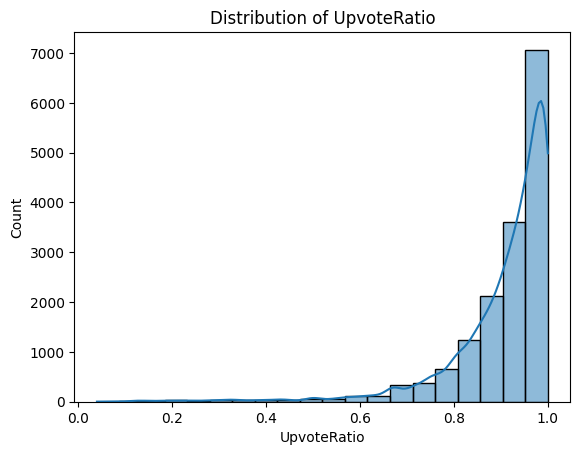

In [6]:
sns.histplot(df['UpvoteRatio'], bins=20, kde=True)
plt.title('Distribution of UpvoteRatio')
plt.show()

In [7]:
df['UpvoteRatioCategory'] = pd.cut(df['UpvoteRatio'], bins=3, labels=['Low', 'Medium', 'High'])

In [8]:
df.drop(['UpvoteRatio','IsPinned'], axis=1, inplace=True)

## Cleaning Author column

In [9]:


author_counts = df['Autor'].value_counts()

# Create a DataFrame with author names and their corresponding counts
author_df = pd.DataFrame({'Autor': author_counts.index, 'Count': author_counts.values})

# Plot a pie chart using Plotly
fig = px.pie(author_df, values='Count', names='Autor', title='Author Contribution',
             labels={'Author': 'Author Name', 'Count': 'Number of Posts'})

# Customize the layout if needed
fig.update_traces(textposition='inside', textinfo='percent+label')

# Show the plot
fig.show()


In [10]:
author_counts = df['Autor'].value_counts()

# Display the author counts in text
print("Author Contribution:")
print(author_counts)

Author Contribution:
Autor
avogadros_number      2334
silence7              1169
LudovicoSpecs          403
GeraldKutney           341
boppinmule             295
                      ... 
TheDoomsdayPopTart       1
Potential-One2235        1
JuliusK444               1
I_HALF_CATS              1
xabby                    1
Name: count, Length: 2455, dtype: int64


In [11]:
null_values = df['Autor'].isnull().sum()
print("Number of null values in Autor column:", null_values)

Number of null values in Autor column: 457


In [12]:
unique_names = [f'unique_name_{i}' for i in range(1, 1000000)]
df['Autor'].fillna(pd.Series(unique_names), inplace=True)

We just replace the unique values with the null values because at last we gonna apply label encoding to this column it will not affect on any values

## We will just deal with Time column

In [13]:
# Now cleaning the Time column's data
df['Time'] = pd.to_datetime(df['Time'], unit='s')

df['Year'] = df['Time'].dt.year
df['Month'] = df['Time'].dt.month
df['Day'] = df['Time'].dt.day
df['Hour'] = df['Time'].dt.hour

df['TimeOfDay'] = pd.cut(df['Time'].dt.hour, bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

df['IsWeekend'] = df['Time'].dt.weekday // 5 == 1

In [14]:
df.drop(columns=['Time'], inplace=True)

In [15]:
# Converting categorical columns to numerical values
time_of_day_mapping = {'Night': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3}
df['TimeOfDay'] = df['TimeOfDay'].map(time_of_day_mapping)

df['IsWeekend'] = df['IsWeekend'].astype(int)

df = pd.get_dummies(df, columns=['IsWeekend'], prefix='IsWeekend', drop_first=True)

In [16]:
binary_columns = ['IsWeekend_1']

for column in binary_columns:
    df[column] = df[column].astype(int)

In [17]:
df['TimeOfDay'].fillna(df['TimeOfDay'].mode().iloc[0], inplace=True)

In [18]:
average_score_by_year = df.groupby('Year')['Score'].mean().reset_index()

fig = px.bar(average_score_by_year, x='Year', y='Score', text='Score', title='Average Score by Year')
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.show()

Note:

Now that we created the 'Year' column, we did a parenthesis to analyze the changes in Score over time; we note that there were higher scores in 2016 and 2017, and then this metric went down to increase again in 2022. As Score takes into account the number of votes, we can also say that the participation in the posts has changed year by year without a noticeable trend.

In [19]:
df.head()

,Title,Score,Autor,Comments,Subreddit,is_nsfw,IsSelfText,IsStickied,IsLocked,Sentiment_hf,UpvoteRatioCategory,Year,Month,Day,Hour,TimeOfDay,IsWeekend_1
0,I'm afraid climate change is going to kill me!...,718,Will_Power,534,climatechange,False,True,True,False,negative,High,2019,2,14,0,2,0
1,The r/climatechange Verified User Flair Program,30,technologyisnatural,14,climatechange,False,True,True,False,positive,High,2022,8,21,20,3,1
2,How come some environmentalists are against ca...,75,SnooMarzipans7682,296,climatechange,False,True,False,False,negative,High,2023,10,22,14,2,1
3,Solar and wind are better than nuclear,21,Consistent_Piano_210,26,climatechange,False,True,False,False,positive,High,2023,10,22,20,3,1
4,When will we hit 2 degrees of global warming?,9,ging289,30,climatechange,False,True,False,False,negative,High,2023,10,22,22,3,1


In [20]:
X = df.drop(['Score'], axis=1)
y = df['Score']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10086)
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (11981, 16)
X_test.shape: (3994, 16)
y_train.shape: (11981,)
y_test.shape: (3994,)


In [22]:
category_columns = ['is_nsfw','IsSelfText','IsStickied','IsLocked','IsWeekend_1','Subreddit','Sentiment_hf','UpvoteRatioCategory']
numeric_columns = ['Comments','Year','Month','Day','Hour','TimeOfDay']

In [23]:
def preprocess_and_vectorize(data, text_column='Title', max_features=1000, min_df=3, max_df=0.6):
    """
    Preprocesses text data and returns a TF-IDF matrix.
    """
    corpus = []
    for i in range(len(data)):
        text = re.sub(r'\W', ' ', str(data[text_column].iloc[i]))
        text = text.lower()
        text = re.sub(r'^br$', ' ', text)
        text = re.sub(r'\s+br\s+',' ', text)
        text = re.sub(r'\s+[a-z]\s+', ' ', text)
        text = re.sub(r'^b\s+', '', text)
        text = re.sub(r'\s+', ' ', text)
        corpus.append(text)

    vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df, max_df=max_df, stop_words=stopwords.words('english'))
    X = vectorizer.fit_transform(corpus).toarray()

    return X

In [24]:
columns_categorical_list = list(category_columns)
columns_numerical_list = list(numeric_columns)

def preprocess_and_vectorize_titles(data):
    return preprocess_and_vectorize(data, text_column='Title')

# Pipeline for categorical features
pipeline_categorical = make_pipeline(
    OneHotEncoder()
)

# Pipeline for numerical features
pipeline_numerical = make_pipeline(
    MinMaxScaler()
)

# Use the preprocess_and_vectorize_titles function directly in the ColumnTransformer
pipeline_full = ColumnTransformer([
    ("categorical", pipeline_categorical, category_columns),
    ("numerical", pipeline_numerical, numeric_columns),
    ("text", FunctionTransformer(preprocess_and_vectorize_titles, validate=False), [0])  # Index 0 corresponds to 'Title' column
])

# Fit and transform on training data
X_train = pipeline_full.fit_transform(X_train)

# Transform on test data
X_test = pipeline_full.transform(X_test)

# Print the transformed shapes
print(f"X_train_transformed.shape: {X_train.shape}")
print(f"X_test_transformed.shape: {X_test.shape}")

X_train_transformed.shape: (11981, 1028)
X_test_transformed.shape: (3994, 1028)


In [25]:
from sklearn.svm import SVC
svc_clf = SVC(probability=True, random_state=42)

# Fit the SVC classifier on the training data
svc_clf.fit(X_train, y_train)

y_pred = svc_clf.predict(X_test)

# To evaluate the model on the test data:
accuracy = svc_clf.score(X_test, y_test)
#Print the accuracy score
print("Accuracy on train data:", svc_clf.score(X_train, y_train))
print("Accuracy on test data:", accuracy)

from sklearn.metrics import accuracy_score
y_test_estimations_2 = svc_clf.predict(X_test)
print(accuracy_score(y_test, y_test_estimations_2))

In [ ]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=50,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42
)

# Fit the XGBClassifier on the training data
xgb_clf.fit(X_train, y_train)

# You can directly use the XGBClassifier for prediction, evaluation, and other tasks.

# For example, to make predictions on the test data:
y_pred = xgb_clf.predict(X_test)

# To evaluate the model on the test data:
accuracy = xgb_clf.score(X_test, y_test)
#Print the accuracy score
print("Accuracy on train data:", xgb_clf.score(X_train, y_train))
print("Accuracy on test data:", accuracy)

from sklearn.metrics import accuracy_score
y_test_estimations_2 = xgb_clf.predict(X_test)
print(accuracy_score(y_test, y_test_estimations_2))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Create the AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)


# Fit the AdaBoostClassifier on the training data
ada_clf.fit(X_train, y_train)

# You can directly use the AdaBoostClassifier for prediction and evaluation

# For example, to make predictions on the test data:
y_pred = ada_clf.predict(X_test)

# To evaluate the model on the test data:
accuracy = ada_clf.score(X_test, y_test)
print("Accuracy on train data:", ada_clf.score(X_train, y_train))
print("Accuracy on test data:", accuracy)

# Alternatively, you can use the accuracy_score function from sklearn.metrics
y_test_estimations_2 = ada_clf.predict(X_test)
print("Accuracy using accuracy_score:", accuracy_score(y_test, y_test_estimations_2))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

# Create the Decision Tree classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Fit the Decision Tree classifier on the training data
dt_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt_clf.predict(X_test)

# Evaluate the model on the test data
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

# Create a Sequential model
model = Sequential()

# Add layers to the model
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=256, validation_data=(X_test, y_test))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss on test data:", loss)
print("Accuracy on test data:", accuracy)

# Compile the model for regression (update loss and metrics)
model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['mse', 'mae'])

# Display model summary
model.summary()